In [1]:
import sys

sys.path.append('../')

In [2]:
import os

ROOT = os.getcwd()
WORK_DIR = os.path.dirname(ROOT)

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pylab as pl

sns.set()

In [99]:
from sklearn.preprocessing import TargetEncoder

## ***Prepare the dataset***

In [4]:
!kaggle datasets download -d mexwell/heart-disease-dataset

100%|█████████████████████████████████████████| 399k/399k [00:00<00:00, 563kB/s]
100%|█████████████████████████████████████████| 399k/399k [00:00<00:00, 562kB/s]


In [5]:
!unzip heart-disease-dataset.zip
!rm -rf heart-disease-dataset.zip

Archive:  heart-disease-dataset.zip
replace documentation.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## ***EDA***

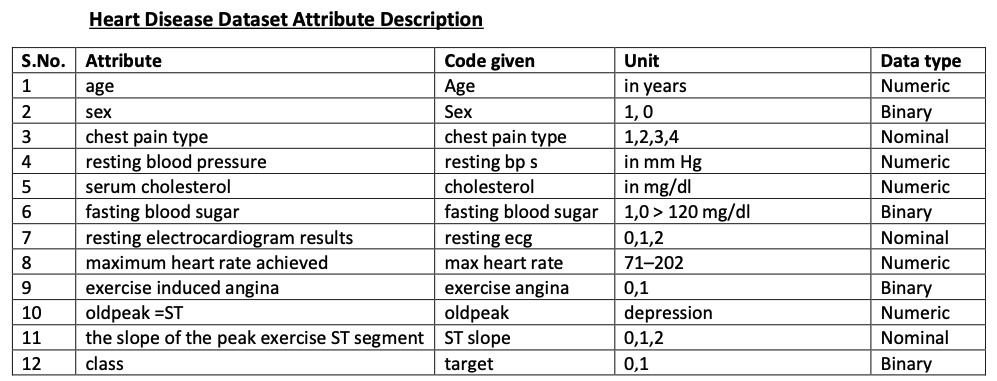

In [6]:
from PIL import Image

Image.open(os.path.join(WORK_DIR, "images/attribute_description.png"))

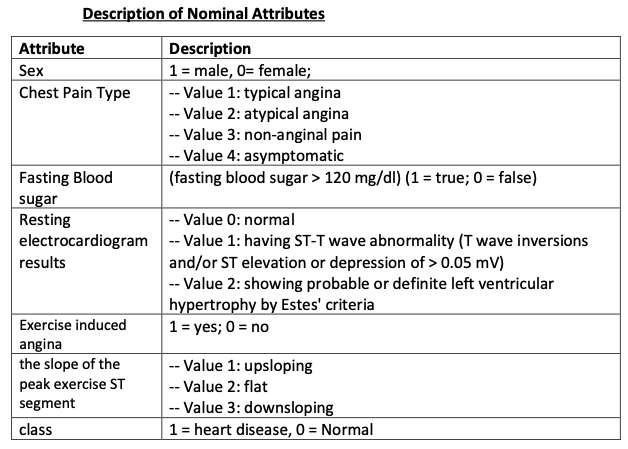

In [7]:
Image.open(os.path.join(WORK_DIR, "images/nominal_attributes.png"))

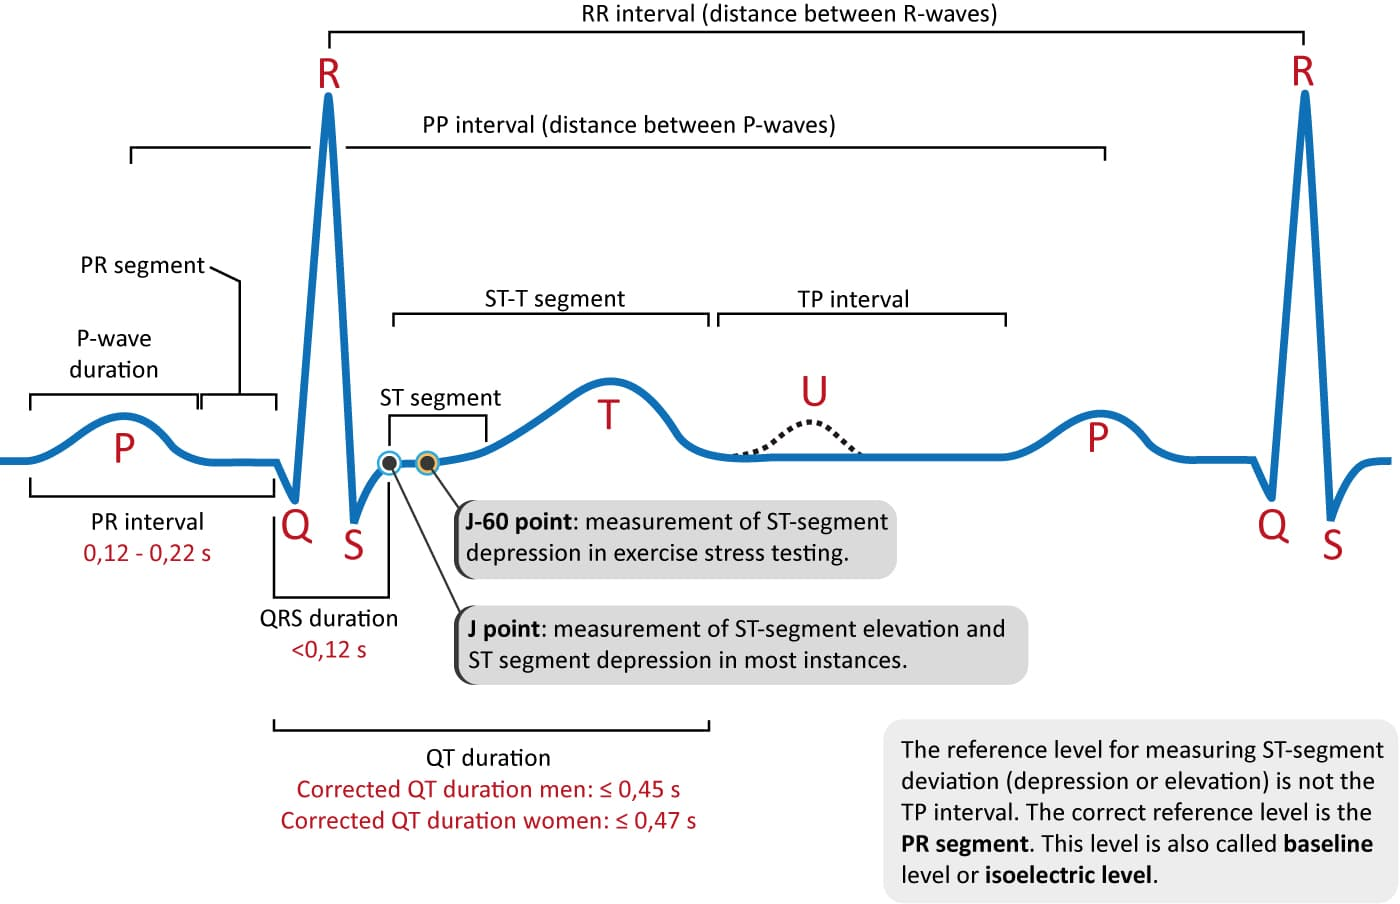

In [8]:
Image.open(os.path.join(WORK_DIR, "images/ecg.jpeg"))

In [9]:
df = pd.read_csv("./heart_statlog_cleveland_hungary_final.csv")

In [25]:
df.head(50)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,ST_slope,is_heart_disease
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
5,39,1,3,120,339,0,0,170,0,0.0,1,0
6,45,0,2,130,237,0,0,170,0,0.0,1,0
7,54,1,2,110,208,0,0,142,0,0.0,1,0
8,37,1,4,140,207,0,0,130,1,1.5,2,1
9,48,0,2,120,284,0,0,120,0,0.0,1,0


In [11]:
df.rename(columns={'chest pain type': "chest_pain_type", 
                   "resting bp s": "resting_blood_pressure", 
                   "fasting blood sugar": "fasting_blood_sugar",
                   "resting ecg": "resting_ecg",
                   "max heart rate": "max_heart_rate",
                   "exercise angina": "exercise_angina",
                   "ST slope": "ST_slope",
                   "target": "is_heart_disease"}, inplace=True)

<AxesSubplot: title={'center': 'The figure for statistics of age-and-female-based heart disease'}, xlabel='age', ylabel='Count'>

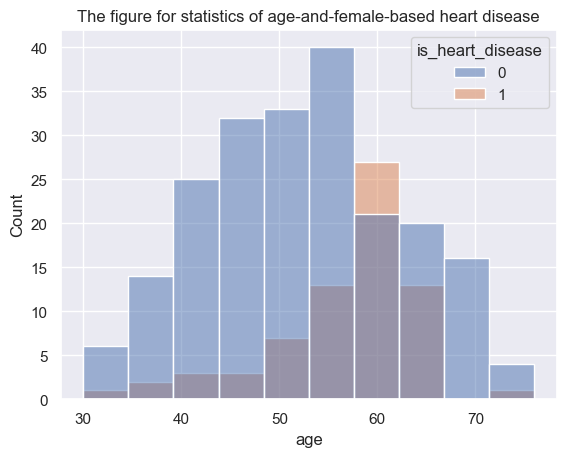

In [20]:
plt.title('The figure for statistics of age-and-female-based heart disease')
sns.histplot(data=df[df['sex'] == 0], x="age", hue="is_heart_disease")

<AxesSubplot: title={'center': 'The figure for chest_pain_type'}, xlabel='chest_pain_type', ylabel='Count'>

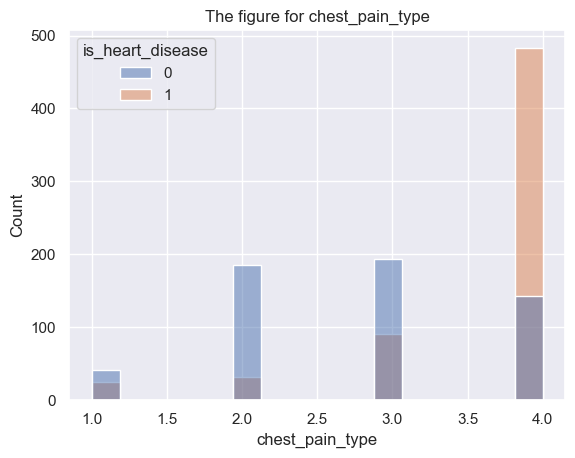

In [24]:
plt.title("The figure for chest_pain_type")
sns.histplot(data=df, x="chest_pain_type", hue="is_heart_disease")

<AxesSubplot: xlabel='cholesterol', ylabel='Count'>

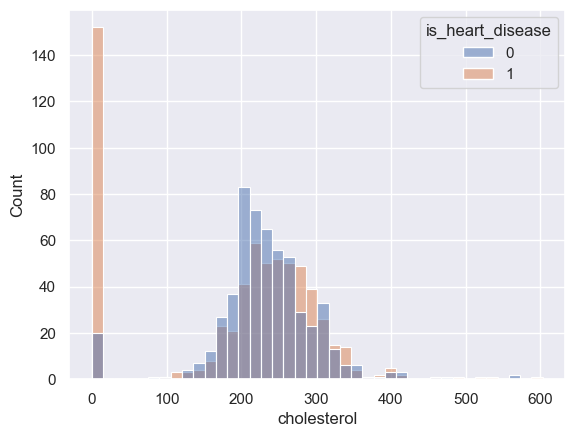

In [31]:
sns.histplot(data=df, x="cholesterol", hue="is_heart_disease")

<AxesSubplot: xlabel='cholesterol', ylabel='Count'>

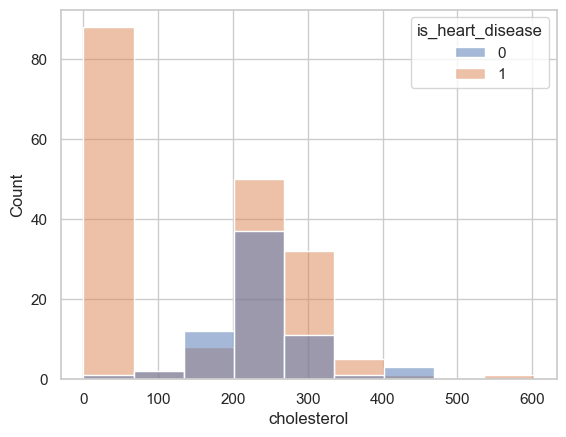

In [97]:
sns.histplot(data=df[df['fasting_blood_sugar'] == 1], x="cholesterol", hue="is_heart_disease")

## ***Data Preprocessing***

In [34]:
df.isna().sum()

age                       0
sex                       0
chest_pain_type           0
resting_blood_pressure    0
cholesterol               0
fasting_blood_sugar       0
resting_ecg               0
max_heart_rate            0
exercise_angina           0
oldpeak                   0
ST_slope                  0
is_heart_disease          0
dtype: int64

<AxesSubplot: ylabel='proportion'>

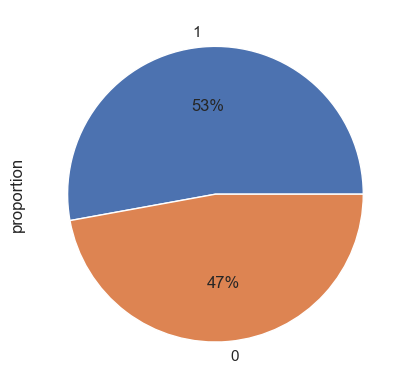

In [43]:
df['is_heart_disease'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')

## ***Data Spliting***

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="is_heart_disease"), df["is_heart_disease"], test_size=0.2, random_state=0)

## ***Feature Engineering***

In [134]:
from typing import List, Tuple, Dict

def binning(data: pd.DataFrame, column: str) -> pd.DataFrame:
    data[f'{column}_binning'], _ = pd.qcut(data[column], 20, retbins=True, labels=False, duplicates='drop')
    
    return data

def set_column_object(data: pd.DataFrame, colunm_category: str, column_numeric: str) -> pd.DataFrame:
    data[f'{colunm_category}_{column_numeric}'] = data[colunm_category].astype('str') + '_' + data[column_numeric].astype(str)
    
    return data

def encoding(data: pd.DataFrame, column_object: str, column_target: str) -> pd.DataFrame:
    
    target_encoding = TargetEncoder()
    target_encoding.fit(data[[column_object]], data[column_target])
    data[f'{column_object}_encoded'] = target_encoding.transform(data[[column_object]])
    
    return data
    
def get_weighted(data: pd.DataFrame, column_object: str) -> Dict[str, float]:
    df_weighted = data[[column_object, f'{column_object}_encoded']].drop_duplicates()
    weighted = dict(zip(df_weighted[column_object], df_weighted[f'{column_object}_encoded']))
    
    return weighted

In [111]:
concat_training_set = pd.concat([X_train, y_train], axis=1)
concat_testing_set = pd.concat([X_test, y_test], axis=1)

### ***sex_age_encoded***

In [117]:
concat_training_set = binning(data=concat_training_set, column='sex')

In [118]:
concat_training_set = set_column_object(concat_training_set, 'sex', 'age')

In [119]:
concat_training_set = encoding(concat_training_set, 'sex_age', 'is_heart_disease')

In [121]:
sex_age_weighted = get_weighted(data=concat_training_set, column_object='sex_age')

In [123]:
concat_testing_set = set_column_object(concat_testing_set, 'sex', 'age')

In [124]:
concat_testing_set['sex_age_encoded'] = concat_testing_set['sex_age'].map(sex_age_weighted)

In [126]:
concat_testing_set['sex_age_encoded'].fillna(0, inplace=True)

### ***fasting_blood_sugar_cholesterol_encoded***

In [128]:
concat_training_set = binning(data=concat_training_set, column='cholesterol')

In [129]:
concat_training_set = set_column_object(concat_training_set, 'fasting_blood_sugar', 'cholesterol')

In [130]:
concat_training_set = encoding(concat_training_set, 'fasting_blood_sugar_cholesterol', 'is_heart_disease')

In [135]:
fasting_blood_sugar_cholesterol_weighted = get_weighted(data=concat_training_set, column_object='fasting_blood_sugar_cholesterol')

In [138]:
concat_testing_set = set_column_object(concat_testing_set, 'fasting_blood_sugar', 'cholesterol')

In [139]:
concat_testing_set['fasting_blood_sugar_cholesterol_encoded'] = concat_testing_set['fasting_blood_sugar_cholesterol'].map(fasting_blood_sugar_cholesterol_weighted)

In [142]:
concat_testing_set['fasting_blood_sugar_cholesterol_encoded'].fillna(0, inplace=True)

## ***Modeling***

In [159]:
X_train = concat_training_set.drop(columns=['is_heart_disease'])
y_train = concat_training_set['is_heart_disease']

In [162]:
X_train.drop(columns=['fasting_blood_sugar_cholesterol', 'fasting_blood_sugar_binning', 'cholesterol_binning', 'sex_binning', 'sex_age', 'age_binning'], inplace=True)

<AxesSubplot: >

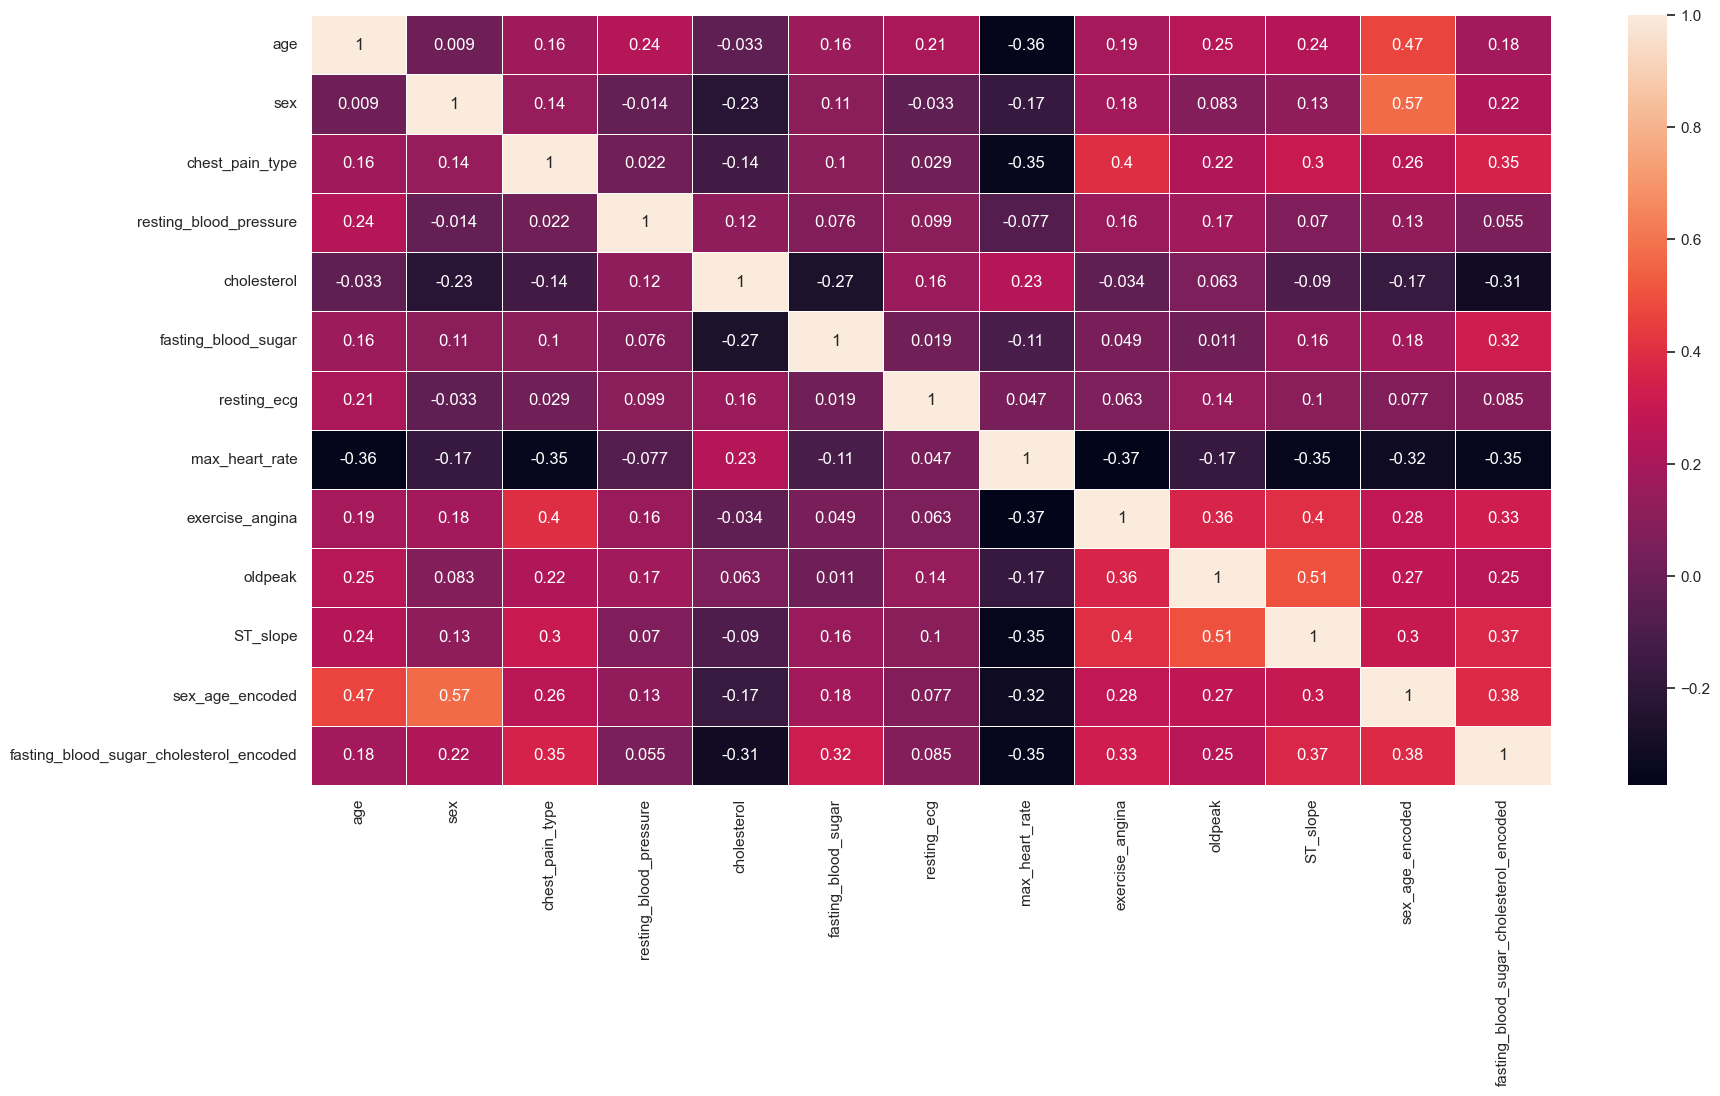

In [163]:
plt.figure(figsize=(20, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5)

In [164]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, criterion='entropy')
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [165]:
X_test = concat_testing_set.drop(columns=['is_heart_disease'])
y_test = concat_testing_set['is_heart_disease']

In [171]:
X_test.drop(columns=['fasting_blood_sugar_cholesterol', 'sex_age'], inplace=True)

In [172]:
predict = model.predict(X_test)

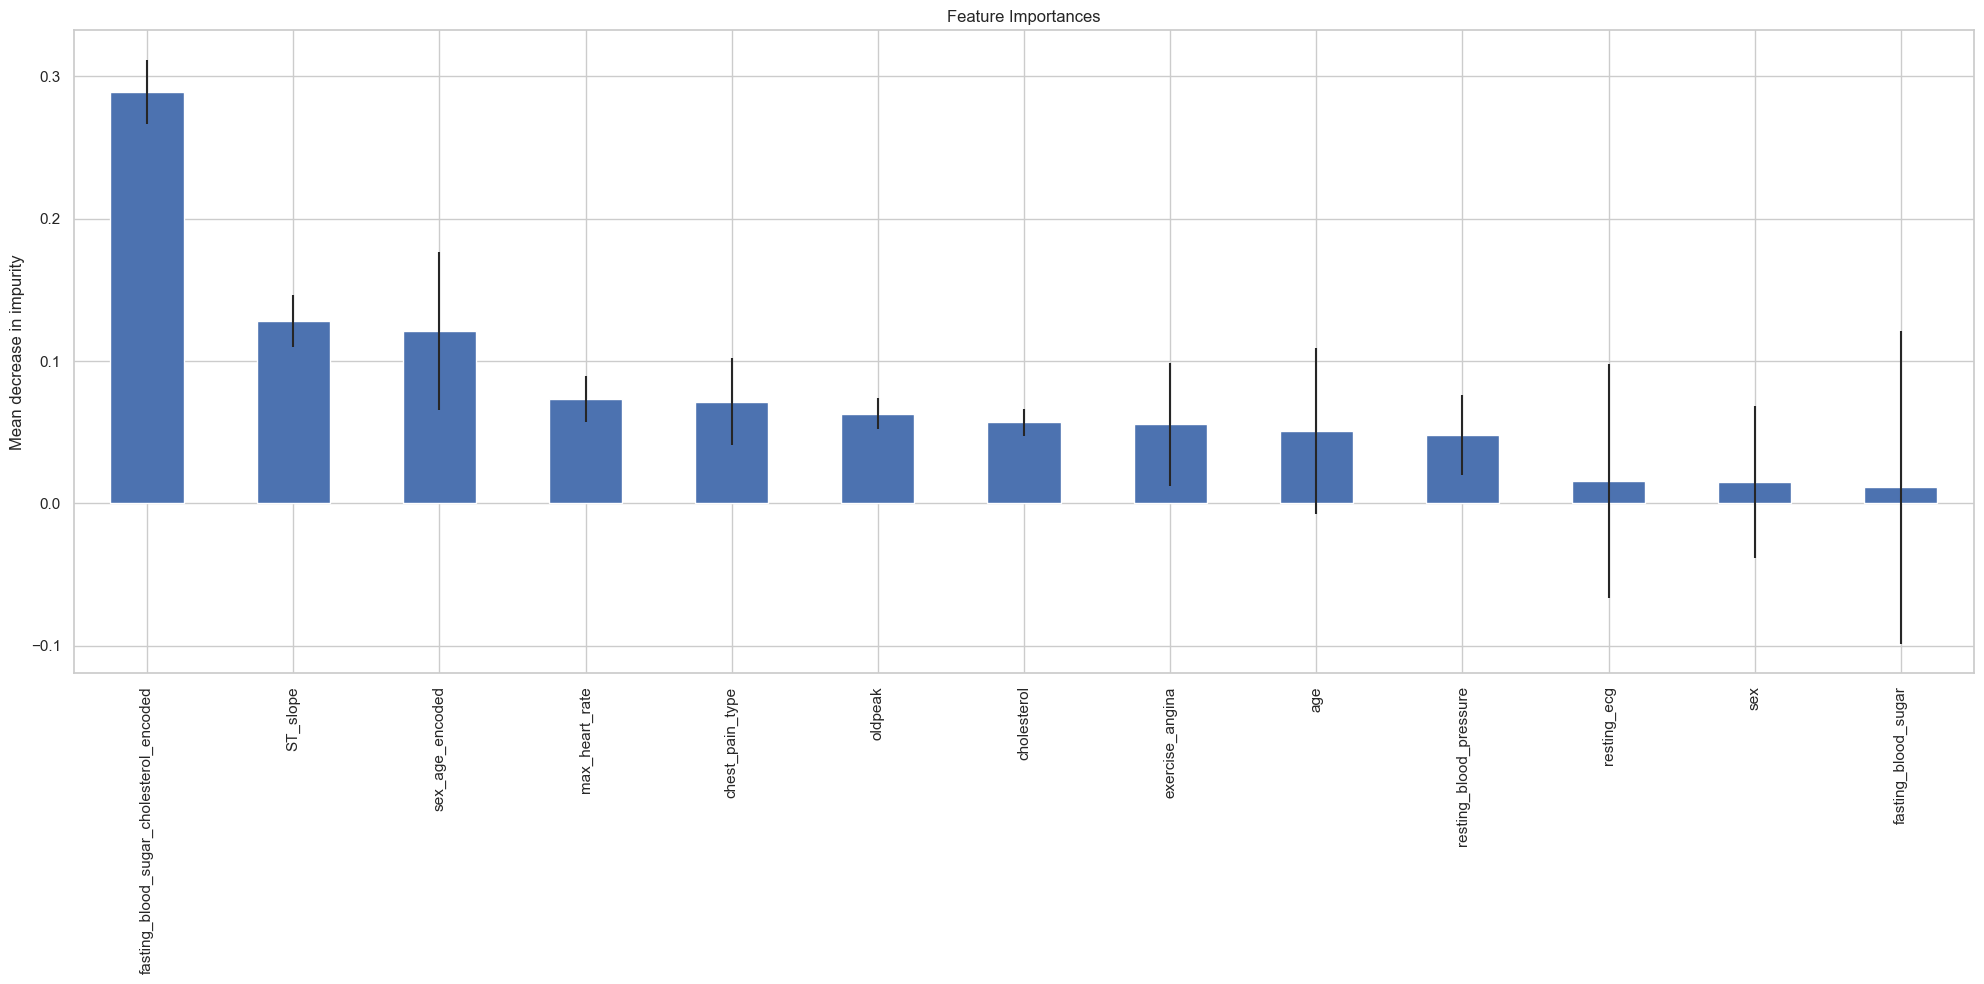

In [178]:
feature_importance = pd.Series(model.feature_importances_, index=X_test.columns.tolist()).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(20,10))
feature_importance.plot.bar(ax=ax, yerr=std)
ax.set_title('Feature Importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [180]:
from sklearn.metrics import classification_report

print(classification_report(predict, y_test))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       124
           1       0.81      0.92      0.86       114

    accuracy                           0.86       238
   macro avg       0.87      0.86      0.86       238
weighted avg       0.87      0.86      0.86       238



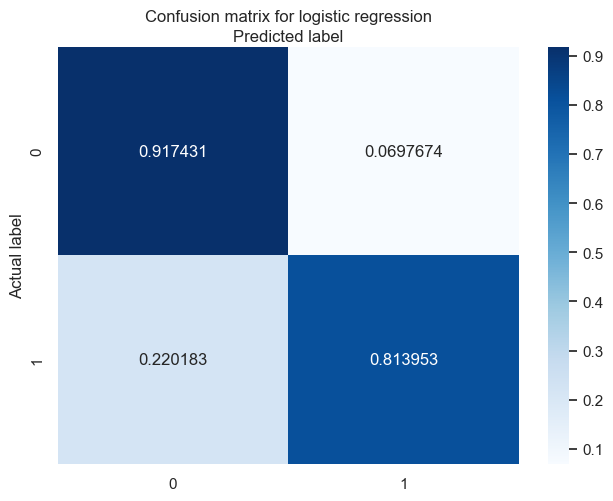

In [189]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test, predict)
C = C / C.astype(np.float64).sum(axis=1)
class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(C), annot = True, cmap = 'Blues', fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix for logistic regression')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

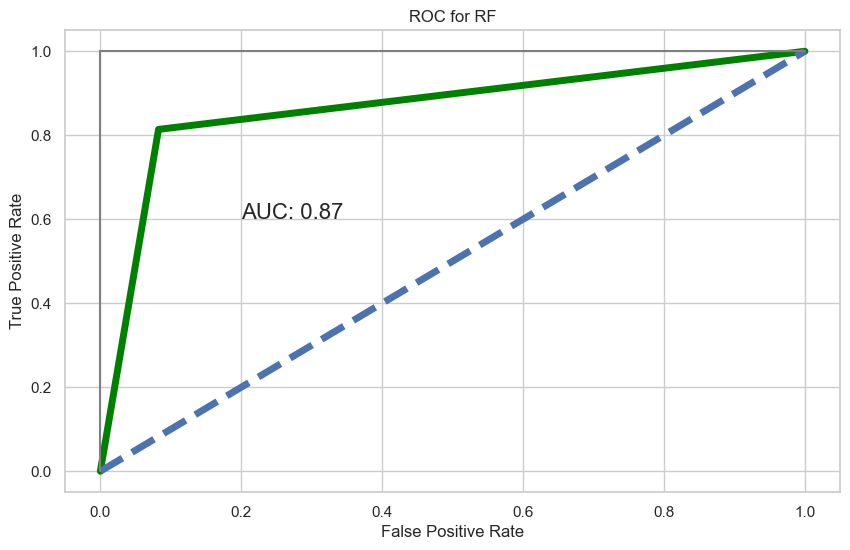

In [190]:
# ROC Curve
from sklearn.metrics import roc_auc_score,roc_curve

false_positive_rate_knn, true_positive_rate_knn, threshold_knn = roc_curve(y_test,predict)
plt.figure(figsize=(10,6))
plt.title('ROC for RF')
plt.plot(false_positive_rate_knn, true_positive_rate_knn, linewidth=5, color='green')
plt.plot([0,1],ls='--',linewidth=5)
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.text(0.2,0.6,'AUC: {:.2f}'.format(roc_auc_score(y_test,predict)),size= 16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()